## L2 Processing Pipeline

In [2]:
using L2Pipeline
using GLMakie
using HDF5

H5SAVE = abspath("../Data/processing_steps.hdf5")
println("Saving data to: \n$(H5SAVE)")

h = h5open(H5SAVE,"w")
close(h)

[ Info: Precompiling L2Pipeline [581c47d6-1f47-4804-be15-364ec46b6059]


Saving data to: 
c:\Users\zvig\.julia\dev\L2Pipeline.jl\Data\processing_steps.hdf5


#### Loading in Calibration Data

In [3]:
caldata = caldata_from_url("C:/Lunar_Imagery_Data/020644_caldata")
println(fieldnames(typeof(caldata)))

(:wvl, :rdn, :obs, :solspec, :statpol, :falpha, :current_step)


#### Applying I/F Correction

In [4]:
rem_solspec(caldata)

h5open(H5SAVE,"cw") do h
    h["solspec_removed"] = caldata.current_step
    return nothing
end

I/F Correction Complete!


#### Applying Statistical Polishing

In [5]:
statistical_polish(caldata)

h5open(H5SAVE,"cw") do h
    h["IoverF_statpol"] = caldata.current_step
    return nothing
end

Cold instrument polishing applied...Statistical Polishing Complete!


#### Applying Thermal Correction

In [6]:
therm = clark_etal(caldata)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02:44


-0.10169623356523827
-0.13084950997950662
-0.23608394271315736
-0.13736083422229406
-0.28465380701157805
-0.19113981227803944
-0.3115127745336759
-0.20359380417718365
-0.251046227624137
-0.1668771842764154
-0.247358945181682
-0.17450429511086774
-0.16582560970189109
-0.09744014059843065
-0.09511415060207962
-0.08602935044044524
-0.08774402319358554
-0.02017953346685797
-0.027976321051503827
-0.044311622873032475
-0.08066493617973958
-0.10188169387872903
-0.08048650861002438
-0.09113755208356422
-0.07543846370410501
-0.0698869384418932
-0.1416604530218477
-0.033973962902117405
-0.05258324776855594
-0.004704758773033557
-0.10831242693642551
-0.008687397526440988
-0.00608307860574131
-0.03111437172054088
-0.03055604608001916
-0.05119540525561206
-0.42525629143831734
-0.36744816772942124


Dict{String, Any} with 12 entries:
  "IOF1"        => [0.0131703 0.0131874 … 0.0134109 0.0144709; 0.0126228 0.0131…
  "ep"          => [0.964882 0.963855 … 0.963811 0.962036; 0.964633 0.964263 … …
  "temp"        => [310.524 316.541 … 252.708 288.645; 314.134 313.69 … 290.634…
  "photo"       => [2.13092 2.12984 … 2.18211 2.18189; 2.1304 2.12938 … 2.18246…
  "ep_wvl"      => [0.971935 0.971913 … 0.970736 0.968426; 0.973108 0.972006 … …
  "i_topo"      => [62.7224 62.701 … 63.6977 63.6938; 62.7106 62.6903 … 63.7027…
  "e_topo"      => [4.24488 4.2574 … 3.62817 3.63076; 4.21082 4.22206 … 3.57938…
  "T1"          => Real[0.00230441 0.00318967 … 4.54348e-5 0.000625906; 0.00280…
  "T2"          => Real[0.000701162 0.00102782 … -999 -999; 0.000947039 0.00055…
  "p2"          => pnts
  "IOF1c"       => [0.0280649 0.0280871 … 0.029264 0.0315739; 0.0268918 0.02799…
  "IOF_notherm" => [0.0280649 0.0280871 … 0.029264 0.0315739; 0.0268918 0.02799…

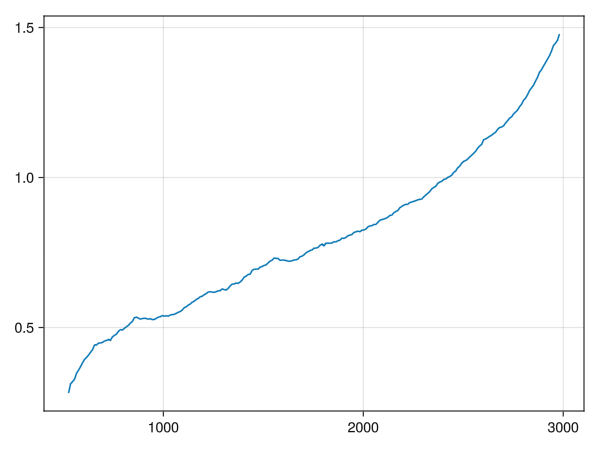

In [10]:
f = Figure(); ax = Axis(f[1,1]); #ax1 = Axis(f[1,2])
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))
idxC = argmin(abs.(caldata.wvl.-2700))
# image!(ax,therm["T1"],interpolate=false)
# image!(ax1,therm["T2"],interpolate=false)
# DataInspector(f)
# display(f)

# hist!(vec(therm["IOF1c"]),bins=100)
# hist!(vec(therm["ep_wvl"]), bins=100)
# println(typeof(therm["ep_wvl"]))
hi_rfl = []
for i in CartesianIndices(axes(caldata.rdn)[1:2])
    x,y = Tuple(i)
    if therm["ep_wvl"][x,y,idxC] < 0
        push!(hi_rfl,therm["IOF1c"][x,y,:])
    end
end
# hist!(vec(therm["T1"][therm["T1"] .!= -999]),bins=100,alpha=0.5)
# println(rand(1:length(hi_rfl)))

lines!(caldata.wvl,hi_rfl[rand(1:length(hi_rfl))])
f



In [12]:
f = Figure(); ax = Axis(f[1,1])
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))
lines!(caldata.wvl,caldata.current_step[xtest,ytest,:])
lines!(caldata.wvl,therm["IOF1"][xtest,ytest,:])
lines!(therm["p2"](xtest,ytest))
scatter!(therm["p2"](xtest,ytest),color=:red)
# lines!(caldata.wvl,therm["IOF1"][xtest,ytest,:])
# scatter!([(1,2),(4,5)])
# println(therm["p2"])
DataInspector(f)
display(f)

GLMakie.Screen(...)

In [18]:
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))

f = Figure()
ax1 = Axis(f[1:3,1],title="Derived Temperature")
ax2 = Axis(f[1:3,2],title="Thermal Radiance")
ax3 = Axis(f[1:3,3],title="Assumed Emissivity")
ax12 = Axis(f[4,1])
ax22 = Axis(f[4,2])
ax32 = Axis(f[4,3])

image!(ax1,therm["temp"],colorrange=(250,350),interpolate=false)
image!(ax2,therm["T1"],colorrange=(0,0.01),interpolate=false)
image!(ax3,therm["ep"],colorrange=(0.8,1),interpolate=false)


hist!(ax12,vec(therm["temp"][therm["temp"].!=-999]))
hist!(ax22,vec(therm["T1"][therm["T1"].!=-999]))
hist!(ax32,vec(therm["ep"][therm["ep"].!=-999]))

for i in [ax12,ax22,ax32]
    hideydecorations!(i)
end

# println(temp_derived)

DataInspector(f)
display(GLMakie.Screen(),f)

GLMakie.Screen(...)

In [35]:
using Statistics
f = Figure(); ax1 = Axis(f[1:3,1]); ax2 = Axis(f[4,1])
sl = IntervalSlider(f[5,1],range=range(extrema(mean(ph_cor,dims=3))...,1000))
xtest = rand(axes(caldata.rdn,1),100)
ytest = rand(axes(caldata.rdn,2),100)
# for (x,y) in zip(xtest,ytest)
#     lines!(ph_cor[x,y])
# end
mean_ph = mean(therm["photo"],dims=3)[:,:,1]
image!(ax1,mean_ph,interpolate=false,colorrange=sl.interval)
hist!(ax2,vec(mean_ph),bins=100)
DataInspector(f)
display(f)

GLMakie.Screen(...)

In [31]:
f = Figure(); ax = Axis(f[1,1])
# lines!(caldata.solspec[1],caldata.solspec[2])
lines!(caldata.wvl,B(caldata.wvl.*10^-9,420.,1.)./(10^6 .* caldata.solspec[2] ./ π))
lines!(caldata.wvl,B(caldata.wvl.*10^-9,340.,1.)./(10^6 .* caldata.solspec[2] ./ π))
xlims!(2000,3000)
ylims!(0,0.15)
display(f)

GLMakie.Screen(...)

In [15]:
f = Figure(); ax= Axis(f[1,1])
image!(IOFc[2,2,:],interpolate=false)
DataInspector(f)
display(GLMakie.Screen(),f)

GLMakie.Screen(...)

In [17]:
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))
fig = Figure()
ga = fig[1,1] = GridLayout()
ax = Axis(ga[1,1])
# ax_im = Axis(fig[2:4,1])

# println(IOF1[xtest,ytest,1:10])
# scatter!(ax,2700,therm[xtest,ytest])
# scatter!(ax,caldata.wvl[a],caldata.current_step[xtest,ytest,a])
# scatter!(ax,caldata.wvl[b],caldata.current_step[xtest,ytest,b])
lines!(ax,caldata.wvl,caldata.current_step[xtest,ytest,:],label="I/F")
lines!(ax,caldata.wvl,therm["IOF1"][xtest,ytest,:],label="Thermal Removed")
lines!(ax,caldata.wvl,therm["IOF1c"][xtest,ytest,:],label="Photometric Correction")
lines!(ax,caldata.wvl,therm["IOF_notherm"][xtest,ytest,:],label="No thermal removal")

Label(fig[0,1],"$(round(therm["T1"][xtest,ytest],digits=3)),$(round(therm["temp"][xtest,ytest],digits=1))",tellwidth=false)
axislegend(ax,position=:lt)
# image!(ax_im,therm .< caldata.current_step[:,:,c],interpolate=false)
# scatter!(ax_im,xtest,ytest,color=:red)
display(GLMakie.Screen(),fig)

GLMakie.Screen(...)

In [7]:
h5open(abspath("../Data/processing_steps.hdf5")) do f
    IoF = f["solspec_removed"][:,:,:]
    stp = f["IoverF_statpol"][:,:,:]
end
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))

["IoverF_statpol", "solspec_removed"]


#### Plotting Results

In [15]:
xtest = rand(axes(caldata.rdn,1))
ytest = rand(axes(caldata.rdn,2))

f = Figure()

ioverf,statpol = h5open(H5SAVE,"r") do h
    return read(h["solspec_removed"]),
           read(h["IoverF_statpol"])
end

ax1 = Axis(f[1,1],ylabel="Radiance")
ax2 = Axis(f[2,1],ylabel="I/F Corrrection")
ax3 = Axis(f[3,1],ylabel="Statistical Polishing")


ax_plot = Axis(f[:,2])

lines!(ax1,caldata.wvl,caldata.rdn[xtest,ytest,:])
lines!(ax2,caldata.wvl,ioverf[xtest,ytest,:])
lines!(ax3,caldata.wvl,statpol[xtest,ytest,:],label="Statistical Polishing")
# lines!(ax3,caldata.wvl,therm[""][xtest,ytest,:],label="Thermal Removal")

image!(ax_plot,caldata.rdn[:,:,240])
scatter!(ax_plot,xtest,ytest,color=:reds)
hidedecorations!(ax_plot)

Label(f[0,:],"Displaying: ($(xtest),$(ytest))")

display(GLMakie.Screen(),f)

LoadError: Unknown color: reds